# Robust Kalman Filtering for Path Retrieval

#### Vinícius Miranda

Please consult the accompanying report for a fuller explanation of the goal of this notebook.

_References:_ [Robust Kalman filtering for vehicle tracking](https://www.cvxpy.org/examples/applications/robust_kalman.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx

### Simulating the data

Across all experimentts, we simulate 1000 time steps for a total duration of 60 seconds. The damping factor is set to 0.05. We shall vary the parametrizations of the unknown input vector and of the measurement noise.

_Experiment 1_

$$\textbf{u}(k)\sim \mathcal{N}(0, I_2)$$

$$
\begin{equation}
  \boldsymbol{\eta}(k) \sim P(X),\text{ where }
  P(X)=
  \begin{cases}
    \mathcal{N}(0, I_2), & \text{if}\ \rho > 0.2 \\
    \mathcal{N}(0, 15I_2), & \text{otherwise}
  \end{cases}
\end{equation}
$$
$$\rho \sim \mathcal{U}(0, 1)$$

_Experiment 2_

$$\textbf{u}(k)\sim \mathcal{N}(0, I_2)$$

$$
\begin{equation}
  \boldsymbol{\eta}(k) \sim P(X),\text{ where }
  P(X)=
  \begin{cases}
    \mathcal{N}(0, I_2), & \text{if}\ \rho > 0.4 \\
    \mathcal{N}(0, 15I_2), & \text{otherwise}
  \end{cases}
\end{equation}
$$

$$\rho \sim \mathcal{U}(0, 1)$$

_Experiment 3_

$$\textbf{u}(k)\sim \mathcal{N}(0, 3I_2)$$

$$
\begin{equation}
  \boldsymbol{\eta}(k) \sim P(X),\text{ where }
  P(X)=
  \begin{cases}
    \mathcal{N}(0, 3I_2), & \text{if}\ \rho > 0.4 \\
    \mathcal{N}(0, 15I_2), & \text{otherwise}
  \end{cases}
\end{equation}
$$

$$\rho \sim \mathcal{U}(0, 1)$$

In [2]:
n_experiments = 3
n = 1000 # timesteps
T = 60 # total duration
ts, delta = np.linspace(0,T, n, endpoint=True, retstep=True)
gamma = .05 # damping factor

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delta/2)*delta
A[1,3] = (1-gamma*delta/2)*delta
A[2,2] = 1 - gamma*delta
A[3,3] = 1 - gamma*delta

B[0,0] = delta**2/2
B[1,1] = delta**2/2
B[2,0] = delta
B[3,1] = delta

C[0,0] = 1
C[1,1] = 1

In [3]:
np.random.seed(164)
outlier_ps      = [0.2, 0.4, 0.4]
input_sigmas    = [1, 1, 3]
noise_sigmas    = [1, 1, 3]
outliers_sigmas = [15, 15, 15]

positions, measurements, inputs = [], [], []
for i, (p, input_s, noise_s, out_s) in enumerate(zip(outlier_ps, input_sigmas, noise_sigmas, outliers_sigmas)):

    positions.append(np.zeros((4,n+1)))
    positions[i][:,0] = [0,0,0,0]
    measurements.append(np.zeros((2,n)))
    
    # generate random input and noise vectors
    inputs.append(input_s*np.random.randn(2,n))
    noise = noise_s*np.random.randn(2,n)

    # add outliers to noise
    inds = np.random.rand(n) <= p
    noise[:,inds] = out_s*np.random.randn(2,n)[:,inds]

    # simulate the system forward in time
    for t in range(n):
        measurements[i][:,t] = C@positions[i][:,t] + noise[:,t]
        positions[i][:,t+1]  = A@positions[i][:,t] + B@inputs[i][:,t]


In [4]:
def experiment_plot_helper(true, observed, axis):
    
    colors = ['ro', 'bo', 'go']
    n_cols = len(true)
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    
    for i in range(n_cols):
        ax[0,i].plot(true[i][0,:], true[i][1,:], colors[i], alpha=.1)
        ax[1,i].plot(observed[i][0,:], observed[i][1,:], colors[i], alpha=.1)
        ax[0,i].axis(axis[i])
        ax[1,i].axis(axis[i])
        ax[0,i].set_title("Experiment {}: True".format(i+1))
        ax[1,i].set_title("Experiment {}: Measured".format(i+1))
        
    plt.show()  

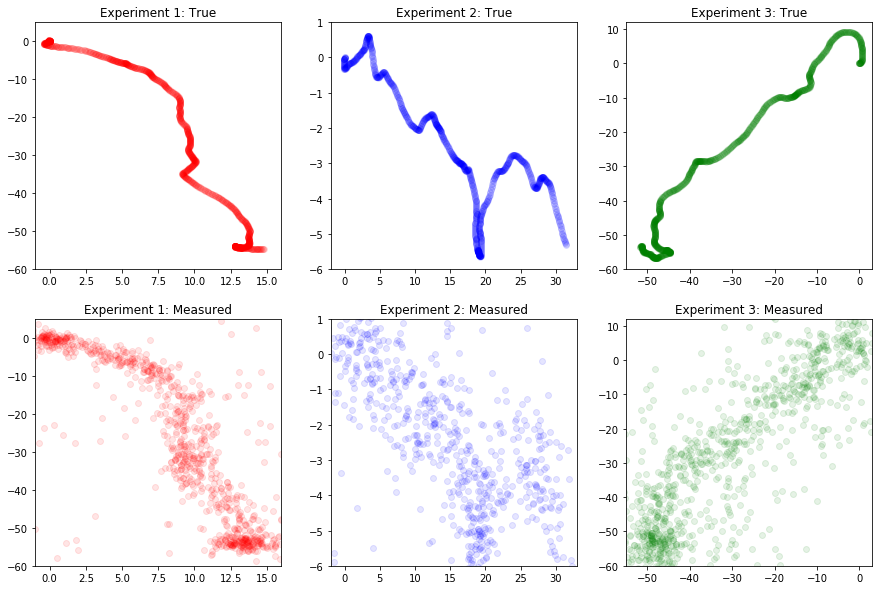

In [5]:
experiment_plot_helper(positions, measurements, [[-1, 16, -60, 5], [-2, 33, -6, 1], [-55, 3, -60, 12]])

In [6]:
# We copy the true trajectory since we will now predict it
positions_true = [p.copy() for p in positions]

def simulator(filtering, tau = .1, tau_robust = 2, rho = 2):

    if filtering not in ["Kalman", "Robust Kalman"]:
        raise("Invalid filter type.")
        
    # Parameters
    tau = tau if filtering == "Kalman" else tau_robust
        
    positions_pred, inputs_pred = [], []
    for i in range(n_experiments):

        # Optimization variables
        positions = cvx.Variable(shape=(4, n+1))
        inputs    = cvx.Variable(shape=(2, n))
        noise     = cvx.Variable(shape=(2, n))

        # Objective
        obj = cvx.Minimize(cvx.sum_squares(inputs) + tau*cvx.sum_squares(noise)) \
              if filtering == "Kalman" else \
              cvx.Minimize(cvx.sum_squares(inputs) + \
                           cvx.sum([tau*cvx.huber(cvx.norm(noise[:,t]), rho) for t in range(n)]))

        constr = []
        for t in range(n):
            constr += [ positions[:,t+1]       == A*positions[:,t] + B*inputs[:,t] ,
                        measurements[i][:,t]   == C*positions[:,t] + noise[:,t]   ]

        cvx.Problem(obj, constr).solve()

        positions_pred.append(np.array(positions.value))
    return positions_pred

In [7]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

pos_results = {}
parametrizations = [("Kalman", 0.01), ("Kalman", 0.1), ("Kalman", 1), ("Kalman", 10),
                    ("Robust Kalman", None, 1, 1), ("Robust Kalman", None, 1, 10), 
                    ("Robust Kalman", None, 10, 1), ("Robust Kalman", None, 10, 10)]

for par in parametrizations:
    pos_results[par] = simulator(*par)

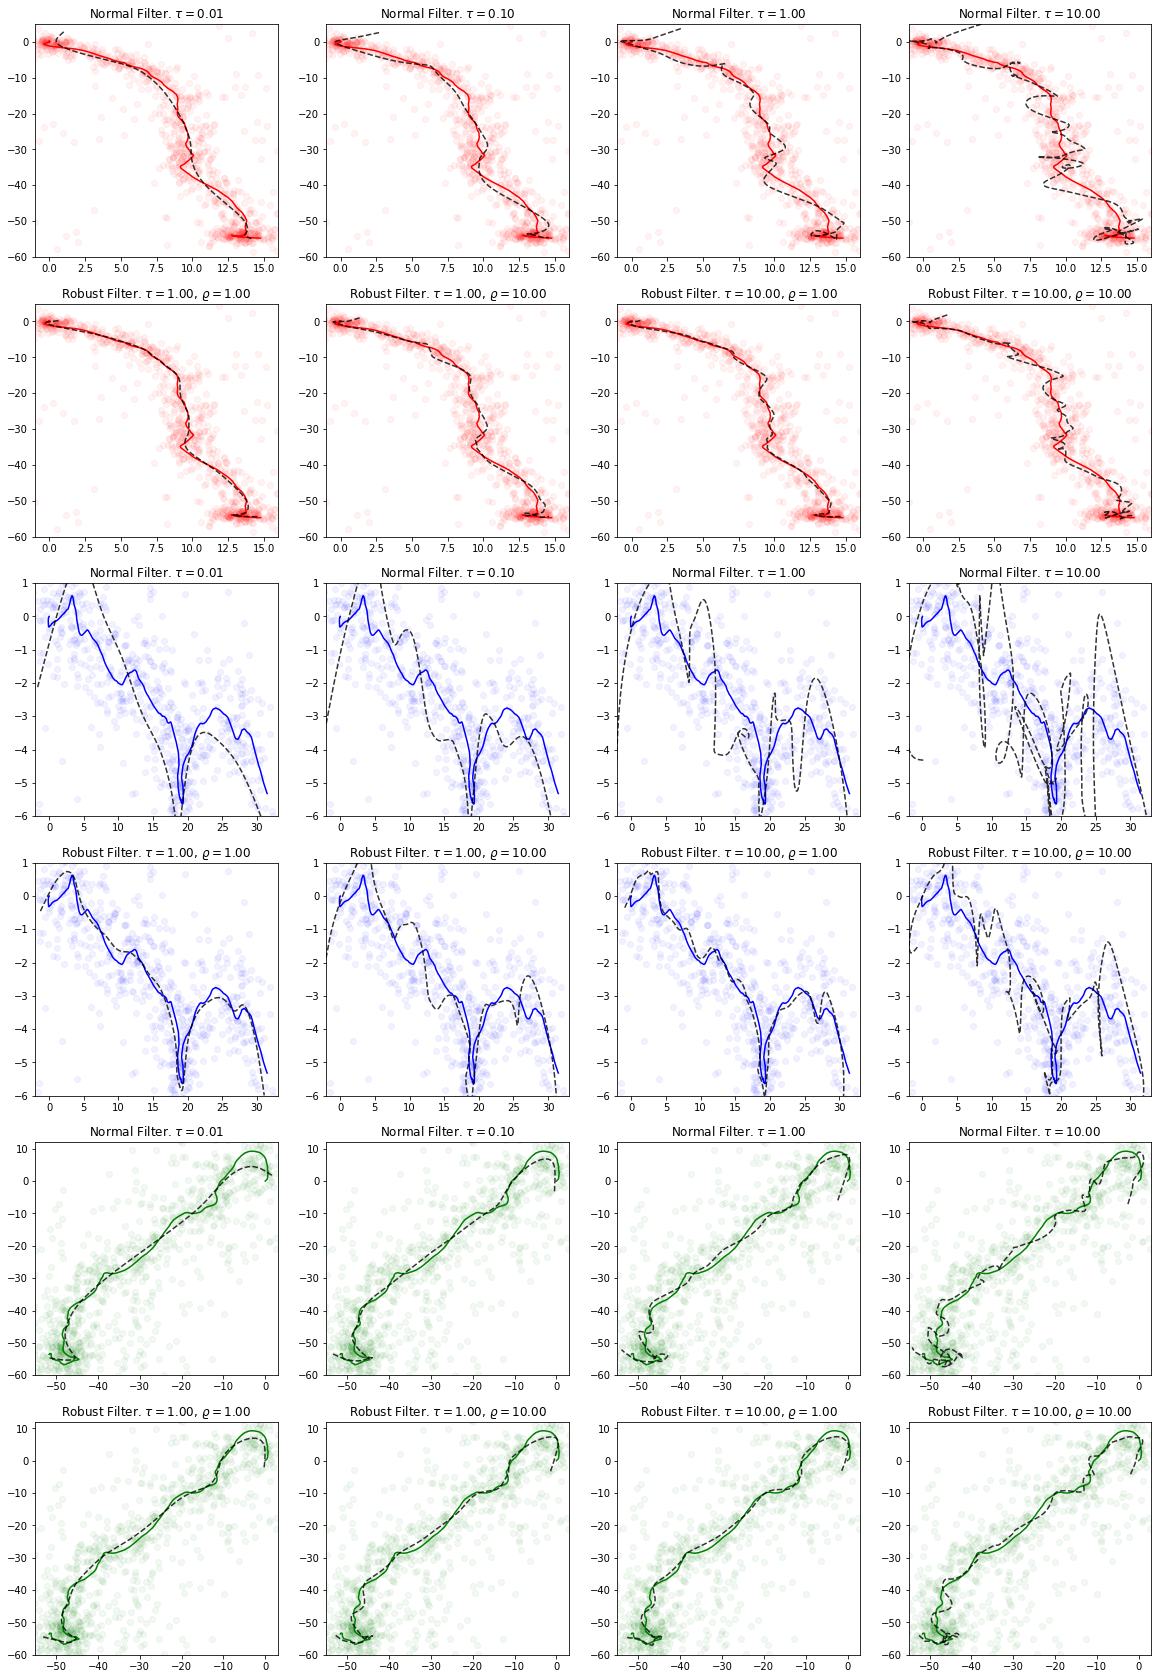

In [11]:
fig, ax = plt.subplots(6, 4, figsize=(20, 30))
clr = ['r', 'b', 'g']

for k, ax_lim in enumerate([[-1, 16, -60, 5], [-2, 33, -6, 1], [-55, 3, -60, 12]]):
    for i, par in enumerate(parametrizations):

        if i < 4:
            ax[2*k, i].plot(positions_true[k][0,:], positions_true[k][1,:], clr[k]+'-')
            ax[2*k, i].plot(measurements[k][0,:], measurements[k][1,:], clr[k]+'o', alpha=.05)
            ax[2*k, i].plot(pos_results[par][k][0,:], pos_results[par][k][1,:], 'k--', alpha=.8)
            ax[2*k, i].axis(ax_lim)
            ax[2*k, i].set_title(r"Normal Filter. $\tau = {:.2f}$".format(par[1]))

        else:
            ax[2*k+1, i - 4].plot(positions_true[k][0,:], positions_true[k][1,:], clr[k]+'-')
            ax[2*k+1, i - 4].plot(measurements[k][0,:], measurements[k][1,:], clr[k]+'o', alpha=.05)
            ax[2*k+1, i - 4].plot(pos_results[par][k][0,:], pos_results[par][k][1,:], 'k--', alpha=.8)
            ax[2*k+1, i - 4].axis(ax_lim)
            ax[2*k+1, i - 4].set_title(r"Robust Filter. $\tau = {:.2f}$, $\varrho = {:.2f}$".format(par[2], par[3]))
            
plt.show()